# Crystal Structure Prediction via Ionic Substitutions

This notebook demonstrates how to use the `SMACT` _structure_prediction_ module.

## 1. Getting Started
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WMD-group/SMACT/blob/master/docs/tutorials/structure_prediction.ipynb)

In [ ]:
# Install the required packages
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet

In [ ]:
# Import the required packages
import os
from operator import itemgetter

import pandas as pd

from smact.structure_prediction.database import StructureDB, parse_mprest
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.utilities import parse_spec, unparse_spec
from pymatgen.ext.matproj import MPRester
import pymatviz as pmv
from pymatgen.core import SETTINGS


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="notebook")

## 2. Introducing the Structure Prediction Module

### The `SmactStructure` class

Here we will introduce users to the `SmactStructure` class which is used in the Structure Prediction module to represent structures. We can create instances of the `SmactStructure` class from POSCAR files, pymatgen `Structure` objects, or directly from a list of atomic positions and lattice vectors. We can also get the `SmactStructure` from the Materials Project database using the `from_mp` method.

For the example below, we will get a structure of CsPbI<sub>3</sub> from the Materials Project.

In [ ]:
# We need to specify a list containing tuples of (element, oxidation state, stoichiometry)
cspbi3_species = [("Cs", 1, 1), ("Pb", 2, 1), ("I", -1, 3)]

cspbi3_sstruct = SmactStructure.from_mp(species=cspbi3_species)

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

SmactStructure object:
Cs1+ I1- Pb2+
1.0
6.27514229 0.0 -0.0
0.0 6.27514229 0.0
0.0 0.0 6.27514229
Cs I Pb
1 3 1
Cartesian
3.137571145 3.137571145 3.137571145 Cs1+
0.0 0.0 3.137571145 I1-
0.0 3.137571145 0.0 I1-
3.137571145 0.0 0.0 I1-
0.0 0.0 0.0 Pb2+



<Axes: >

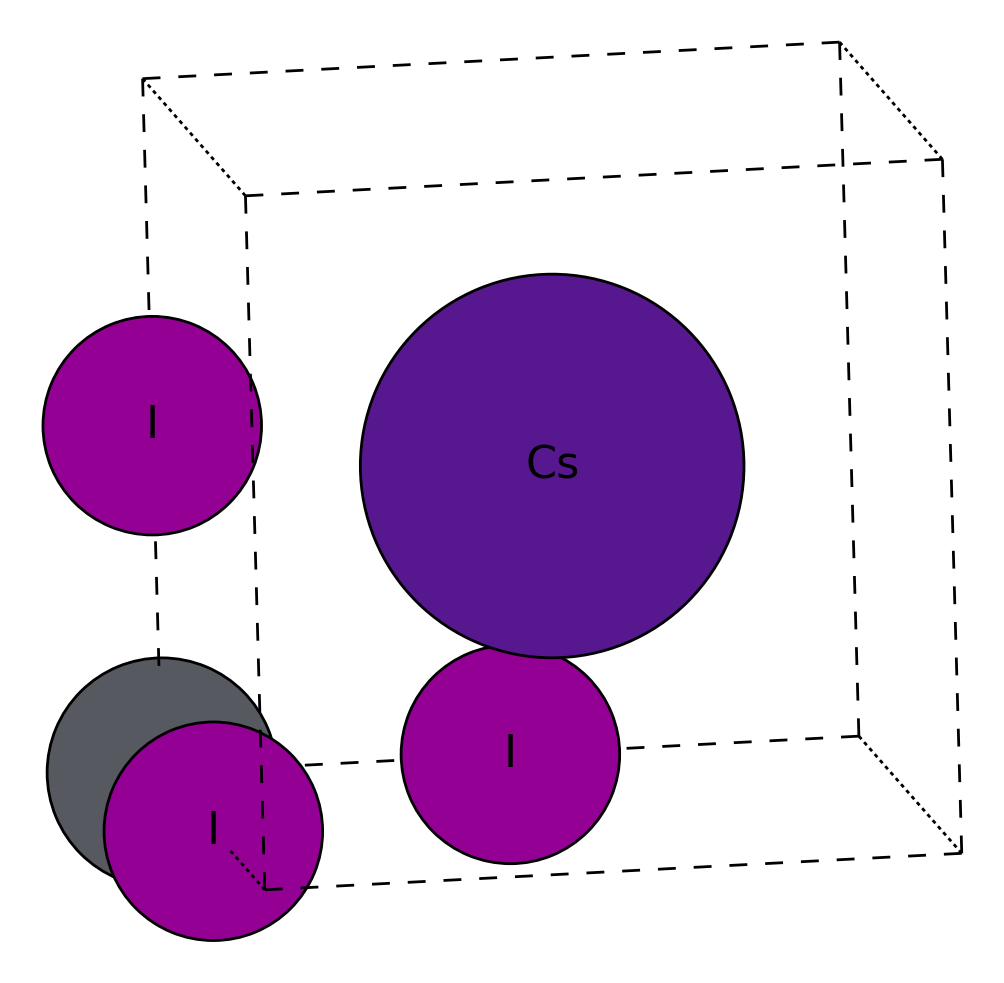

In [ ]:
# We can print the SmactStructure object. This will show the structure in a POSCAR-like format
print("SmactStructure object:")
print(cspbi3_sstruct)

# We can visualise the structure as well
pmv.structure_2d(cspbi3_sstruct.as_py_struct())

For a `SmactStructure` object, we can get the list of species present

In [ ]:
# Print the species in CsPbI3
print(f"Species in CsPbI3:")
print("Element, Valence, Stoichiometry")
for spec in cspbi3_sstruct.species:
    print(spec)

# We can also print out just the string representation of the species
print(f"\nSpecies in CsPbI3: {cspbi3_sstruct.get_spec_strs()}")

# We can also check if a SmactStructure contains a specific species
has_cs1 = cspbi3_sstruct.has_species(("Cs", 1))
print(f"\nDoes the CsPbI3 structure contain Cs?: {has_cs1}")

Species in CsPbI3:
Element, Valence, Stoichiometry
('Cs', 1, 1)
('I', -1, 3)
('Pb', 2, 1)

Species in CsPbI3: ['Cs1+', 'I1-', 'Pb2+']

Does the CsPbI3 structure contain Cs?: True


We will return to using the `SmactStructure` object in the next section.

### The `CationMutator` class

Here we will introduce users to the CationMutator in `smact.structure_prediction.mutation` module. The `CationMutator` class is used to handle the substitution probabilities of different ionic species. 

We can use the `sub_prob` method to get the substitution probabilities of two different ionic species. The `sub_prob` method takes two arguments, the first argument is the ionic species to be substituted, and the second argument is the ionic species to be substituted with. The `sub_prob` method returns the substitution probability of the two ionic species.

Additionally, the `pair_corr` method computes the pair correlation.

In [ ]:
# Instantiate the CationMutator class

mutator = CationMutator.from_json()  # This gets the pymatgen lambda table when no arguments are passed

# Calculate the probability of Ba2+ replacing Sr2+,  Ba2+ replacing Cs1+ and Ba2+ replacing Li1+ in the lambda table

p_Ba_Sr = mutator.sub_prob("Ba2+", "Sr2+")
p_Ba_Cs = mutator.sub_prob("Ba2+", "Cs1+")
p_Ba_Li = mutator.sub_prob("Ba2+", "Li1+")

# Calculate the pair correlation function for Ba2+ replacing Sr2+,  Ba2+ replacing Cs1+ and Ba2+ replacing Li1+ in the lambda table
g_Ba_Sr = mutator.pair_corr("Ba2+", "Sr2+")
g_Ba_Cs = mutator.pair_corr("Ba2+", "Cs1+")
g_Ba_Li = mutator.pair_corr("Ba2+", "Li1+")

# Print the results
print(f"The probability of Ba2+ replacing Sr2+ is {p_Ba_Sr:.3g} and the pair correlation is {g_Ba_Sr:.3g}")
print(f"The probability of Ba2+ replacing Cs1+ is {p_Ba_Cs:.3g} and the pair correlation is {g_Ba_Cs:.3g}")
print(f"The probability of Ba2+ replacing Li1+ is {p_Ba_Li:.3g} and the pair correlation is {g_Ba_Li:.3g}")

The probability of Ba2+ replacing Sr2+ is 0.00276 and the pair correlation is 3.86
The probability of Ba2+ replacing Cs1+ is 0.00569 and the pair correlation is 3.99
The probability of Ba2+ replacing Li1+ is 2.21e-05 and the pair correlation is 0.038


From the above outputs, we can see that Ba<sup>2+</sup> is more likely to be substituted with Cs<sup>+</sup>, compared to Sr<sup>2+</sup> with Li<sup>+</sup> being two orders of magnitude less likely.

The `CationMutator` can also be used to produce a list of possible structures with the `unary_substitute` method. The `unary_substitute` method takes a `SmactStructure` object and returns a list of `SmactStructure` objects with the cations substituted according to the substitution probabilities.

Number of candidate structures: 59
Composition of the first candidate structure:
AgPbI3
The probability of Ag1+ replacing Cs1+ in CsPbI3 is 0.0262


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': '1. Cs1 Pb1 I3 (spg=221)'}>,
        <Axes: title={'center': '2. Ag1 Pb1 I3 (spg=221)'}>], dtype=object))

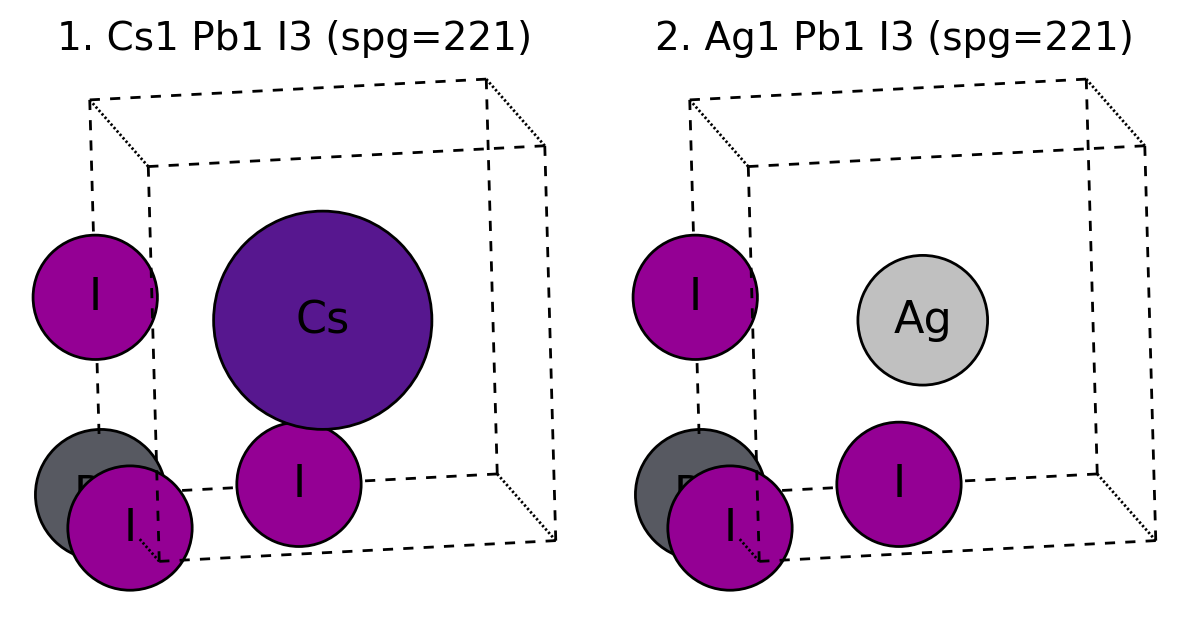

In [ ]:
# Let's substitute on CsPbI3

candidate_structures = list(mutator.unary_substitute(cspbi3_sstruct, thresh=0.001))

# Print the number of candidate structures
print(f"Number of candidate structures: {len(candidate_structures)}")

# Print the composition of the first candidate structure
print(f"Composition of the first candidate structure:")
print(candidate_structures[0][0].reduced_formula())

# Print the probability of the first candidate structure
original_spec = candidate_structures[0][2]
sub_spec = candidate_structures[0][3]
prob = candidate_structures[0][1]
print(f"The probability of {sub_spec} replacing {original_spec} in {cspbi3_sstruct.reduced_formula()} is {prob:.3g}")

# Visualise the original structure and the first candidate structure
pmv.structure_2d([cspbi3_sstruct.as_py_struct(), candidate_structures[0][0].as_py_struct()])

Overall, with the threshold of 1 x 10<sup>-3</sup>, there are 59 possible substituted structures for CsPbI<sup>3</sup>. The returned list isn't sorted by probability, so let's first organise the list.

In [ ]:
# Store the candidate structures in a dataframe

candidate_df = pd.DataFrame(
    candidate_structures, columns=["Structure", "Probability", "Original Species", "Substituted Species"]
)
# Sort the dataframe by probability
candidate_df = candidate_df.sort_values(by="Probability", ascending=False).reset_index(drop=True)

# Show the first 5 rows of the dataframe
candidate_df.head()

,Structure,Probability,Original Species,Substituted Species
0,I1- Pb2+ Rb1+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.165778,Cs1+,Rb1+
1,Br1- Cs1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 ...,0.138700,I1-,Br1-
2,I1- Pb2+ Tl1+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.102270,Cs1+,Tl1+
3,I1- K1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 6....,0.089402,Cs1+,K1+
4,I1- In1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.086309,Cs1+,In1+


From the dataframe above, we can see that the most probable substitution is Cs<sup>+</sup> with Rb<sup>+</sup> with a probability of 0.166, followed by the substitution of of I<sup>-</sup> with Br<sup>-</sup> with a probability of 0.139.

(<Figure size 1800x1200 with 6 Axes>,
 array([[<Axes: title={'center': '1. Cs1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '2. Rb1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '3. Cs1 Pb1 Br3 (spg=221)'}>],
        [<Axes: title={'center': '4. Tl1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '5. K1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '6. In1 Pb1 I3 (spg=221)'}>]],
       dtype=object))

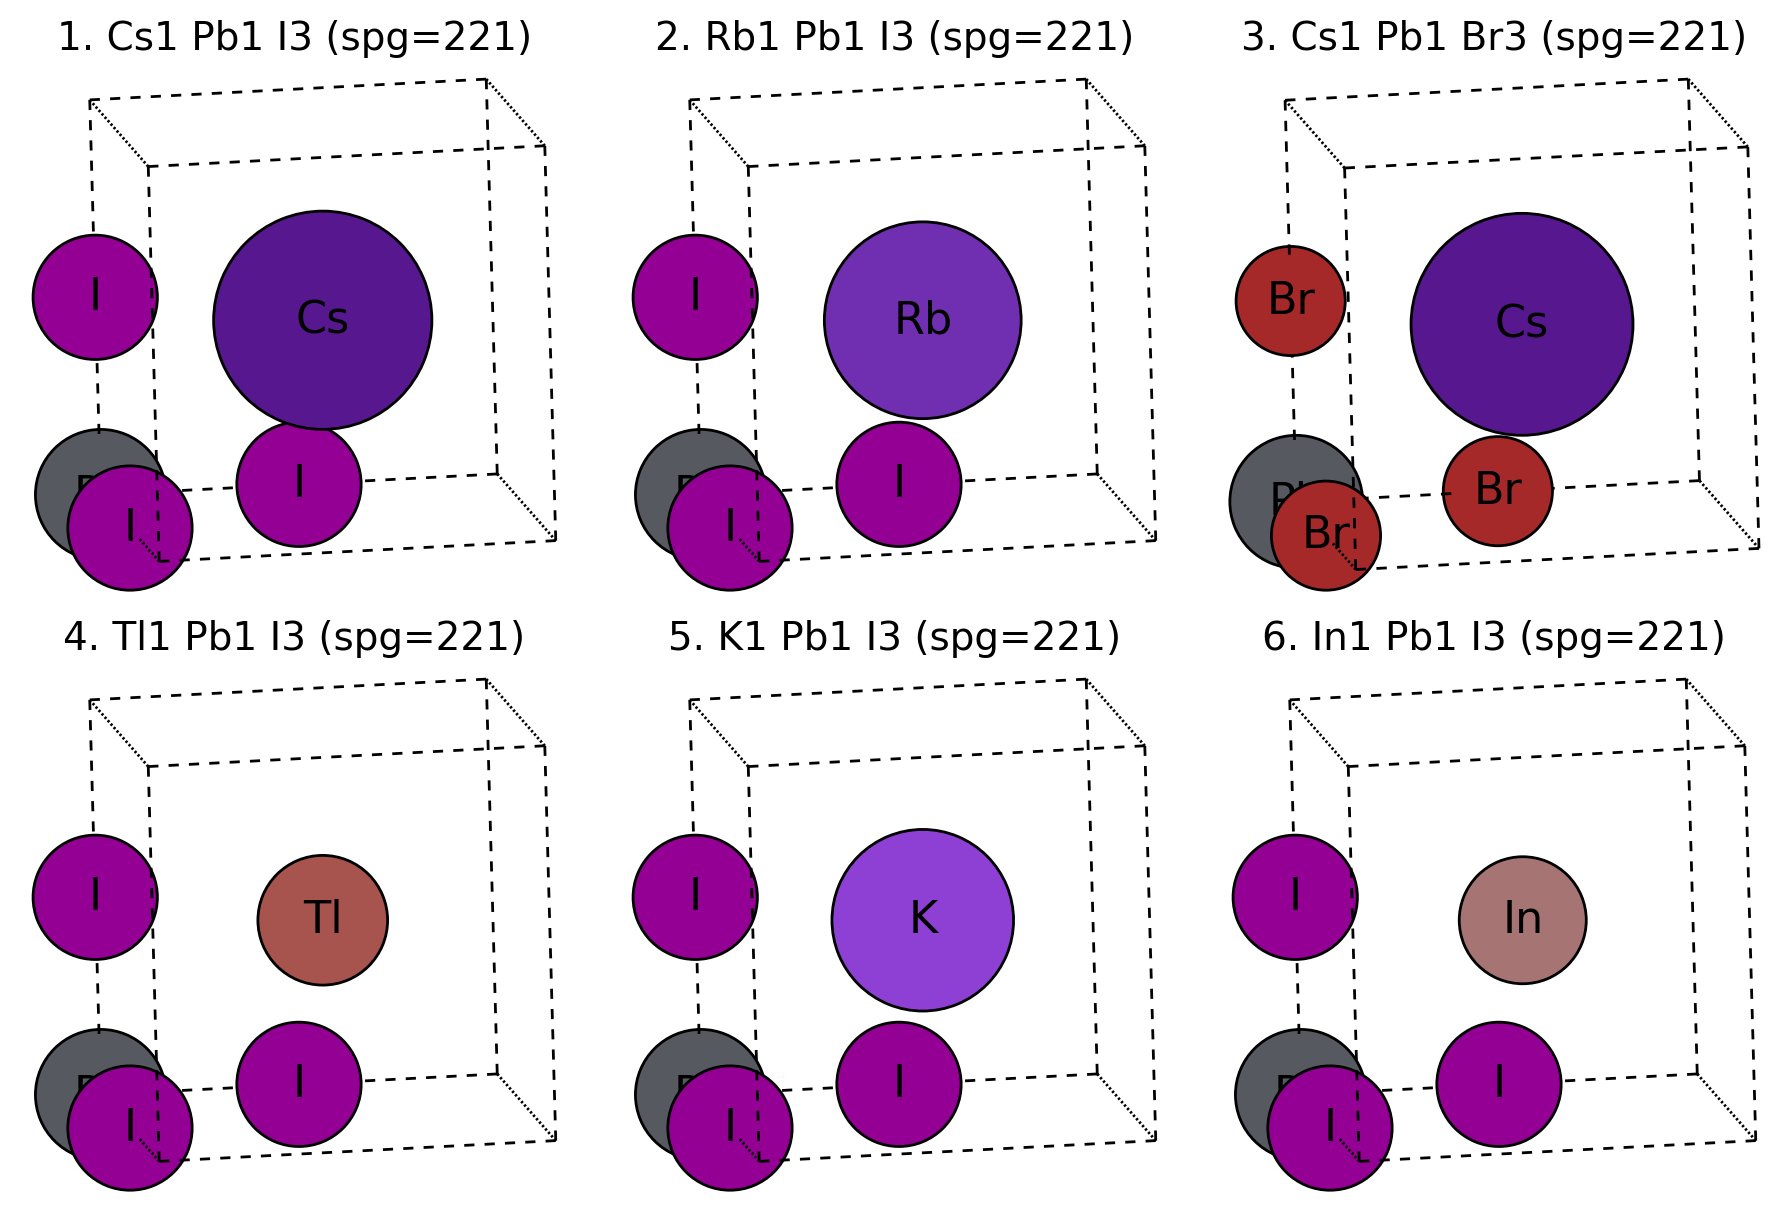

In [ ]:
# Visualise the top 5 candidate structures
top_5_structures = [s.as_py_struct() for s in candidate_df["Structure"].head().to_list()]
pmv.structure_2d([cspbi3_sstruct.as_py_struct()] + top_5_structures, n_cols=3)

### The `StructureDB` class

Here we will introduce users to the `StructureDB` class. This is a minimalist SQLite database that stores `SmactStructure` objects.

In [ ]:
# This either creates a new database or connects to an existing one
#
if os.path.exists("test_db.db"):
    os.remove("test_db.db")
test_db = StructureDB("test_db.db")

# Add a table
test_db.add_table("test_table")

# Add the original structure to the database
test_db.add_struct(struct=cspbi3_sstruct, table="test_table")

# Add the candidate structures to the database
test_db.add_structs(structs=[s[0] for s in candidate_structures], table="test_table")

59

In [ ]:
# Get the structures from the database

# Get structs that contain Cs1+

cs_structs = test_db.get_with_species(species=[("Cs", 1)], table="test_table")

# Print the number of structures
print(f"There are {len(cs_structs)} structures that contain Cs1+")

# Get structs that contain Cs1+ and Pb2+

cs_pb_structs = test_db.get_with_species(species=[("Cs", 1), ("Pb", 2)], table="test_table")

# Print the number of structures

print(f"There are {len(cs_pb_structs)} structures that contain Cs1+ and Pb2+")

There are 42 structures that contain Cs1+
There are 4 structures that contain Cs1+ and Pb2+


The above code blocks demonstrates how to create a `StructureDB` object, store a list of `SmactStructure` objects, and retrieve a list of `SmactStructure` objects from the database by the species present in the structure.

The following example demonstrates how to obtain structures from the Materials Project<sup>*</sup> and store them in the `StructureDB` object. 

<sup>*</sup> The below code assumes that the user has a Materials Project API key from the current (next-gen) version of the MP. If you do not have one, you can obtain one by signing up at https://materialsproject.org/

In [ ]:
# The below function will return a list of perovskite data from the Materials Project database. The specifics of the code are not important for this tutorial.


def get_MP_perovskite_data(api_key=None):
    if api_key is None:
        api_key = os.environ.get("MP_API_KEY") or SETTINGS.get("PMG_MAPI_KEY")
    if api_key is None:
        raise ValueError("No API key found in environment or Pymatgen config file. Please provide an API key.")

    # Get perovskite data from the Materials Project
    with MPRester(use_document_model=False) as mpr:
        robocrys_perov_data = mpr.materials.robocrys.search(keywords=["perovskite"])

    # Get the material ids
    mp_ids = list(set([d.material_id for d in robocrys_perov_data]))

    # Get the ABO3 perovskites
    with MPRester(api_key=api_key, use_document_model=False) as mpr:
        perov_data = mpr.materials.summary.search(
            material_ids=mp_ids,
            theoretical=False,
            formula="ABC3",
            fields=["material_id", "formula_pretty", "structure", "formula_anonymous", "energy_above_hull"],
        )

    return perov_data


# Get the perovskite data
perov_data = get_MP_perovskite_data()

Retrieving RobocrystallogapherDoc documents:   0%|          | 0/9289 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/353 [00:00<?, ?it/s]

In [ ]:
# Parse the data to SmactStructure objects

test_db.add_mp_icsd(table="mp_icsd_perovskites", mp_data=perov_data)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

228

From the above code block we have successfully added 228 out of the 353 ABX<sub>3</sub> perovskite structures from the Materials Project to the `StructureDB` object. Structures which cannot be assigned oxidation states are discarded. We can now use the `StructureDB` object to retrieve structures based on the species present in the structure.

Number of perovskites with different anions:
F1-: 33
Cl1-: 12
Br1-: 6
I1-: 4
O2-: 152
S2-: 9
N3-: 4


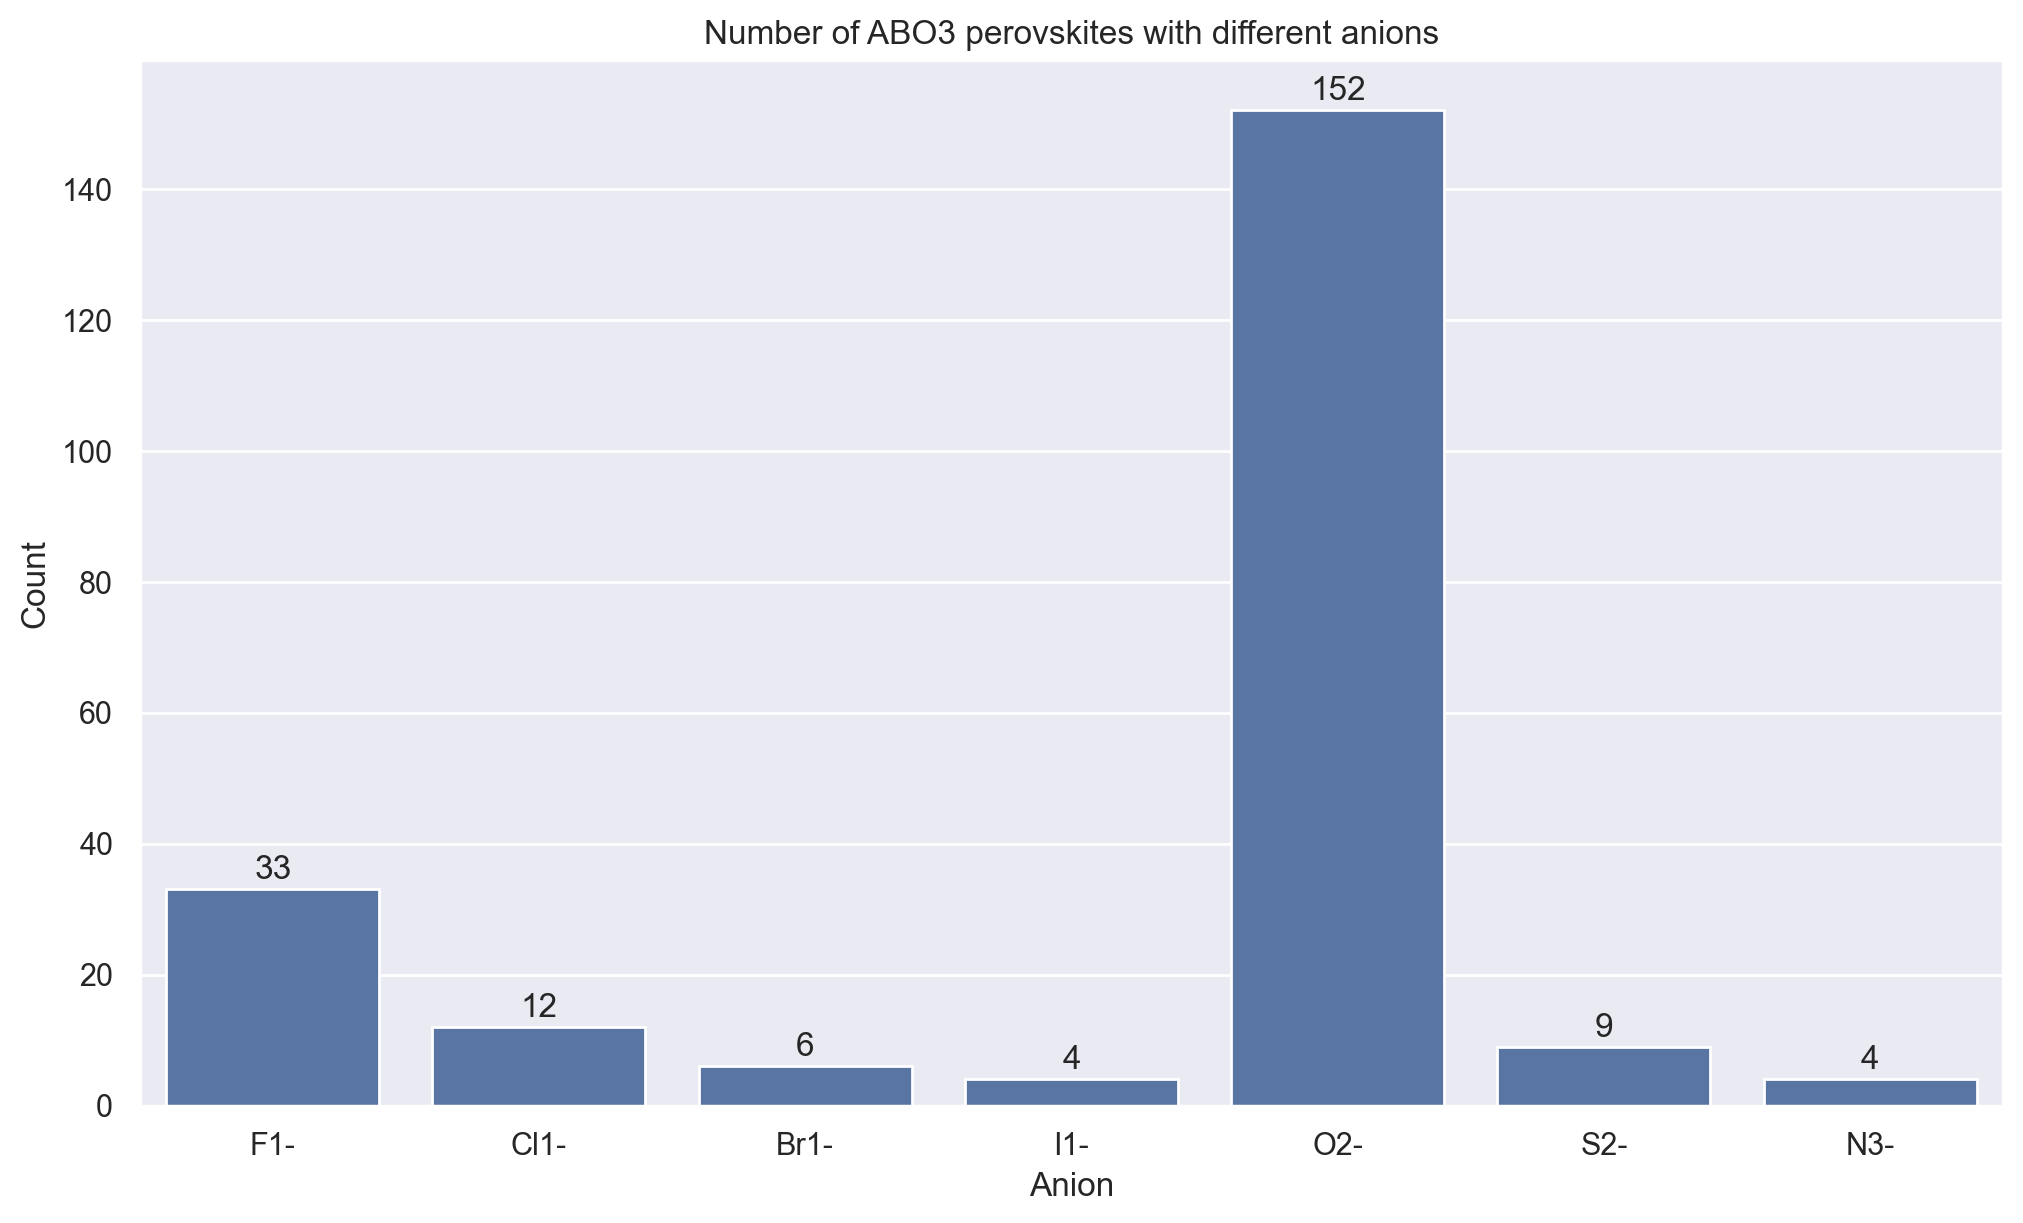

In [ ]:
# Count the number of perovskites with different anions in the database

anions = ["F1-", "Cl1-", "Br1-", "I1-", "O2-", "S2-", "N3-"]

anion_counts_dict = {}

for anion in anions:
    anion_counts_dict[anion] = len(test_db.get_with_species(species=[parse_spec(anion)], table="mp_icsd_perovskites"))

# Print the counts
print("Number of perovskites with different anions:")
for anion, count in anion_counts_dict.items():
    print(f"{anion}: {count}")


# Plot the number of perovskites with different anions
anion_counts_df = pd.DataFrame(anion_counts_dict.items(), columns=["Anion", "Count"])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Anion", y="Count", data=anion_counts_df, ax=ax)
# Show values on the bars
for i, v in enumerate(anion_counts_df["Count"]):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom")

ax.set_title("Number of ABO3 perovskites with different anions")
plt.show()

### The `StructurePredictor` class

With a populated database, we can now introduce the final aspect of the Structure Prediction module, the `StructurePredictor` class. The `StructurePredictor` class is used to predict possible structures of a given composition. The `StructurePredictor` class requires a populated `StructureDB` object and a `CationMutator` object,

In [ ]:
# Instantiate the StructurePredictor class
predictor = StructurePredictor(mutator=mutator, struct_db=test_db, table="mp_icsd_perovskites")

To predict possible structures for a given set of ionic species, we can use the `predict_structs` method. The `predict_structs` method takes a list of ionic species and the probability threshold as arguments. The return format is a generator which yields tuples of the form (predicted structure, probability, original structure).


(N3- Ta5+ Zr4+
1.0
4.064437 0.0 0.0
0.0 4.064437 0.0
0.0 0.0 4.064437
N Ta Zr
3 1 1
Cartesian
2.0322185 0.0 2.0322185 N3-
2.0322185 2.0322185 0.0 N3-
0.0 2.0322185 2.0322185 N3-
2.0322185 2.0322185 2.0322185 Ta5+
0.0 0.0 0.0 Zr4+
, 0.02012124833175394, N3- Ta5+ Th4+
1.0
4.064437 0.0 0.0
0.0 4.064437 0.0
0.0 0.0 4.064437
N Ta Th
3 1 1
Cartesian
2.0322185 0.0 2.0322185 N3-
2.0322185 2.0322185 0.0 N3-
0.0 2.0322185 2.0322185 N3-
2.0322185 2.0322185 2.0322185 Ta5+
0.0 0.0 0.0 Th4+
)

Using a threshold of 0.001, the species ['Zr4+', 'Ta5+', 'N3-'] can be substituted into the structure of ThTaN3 with probability 0.0201


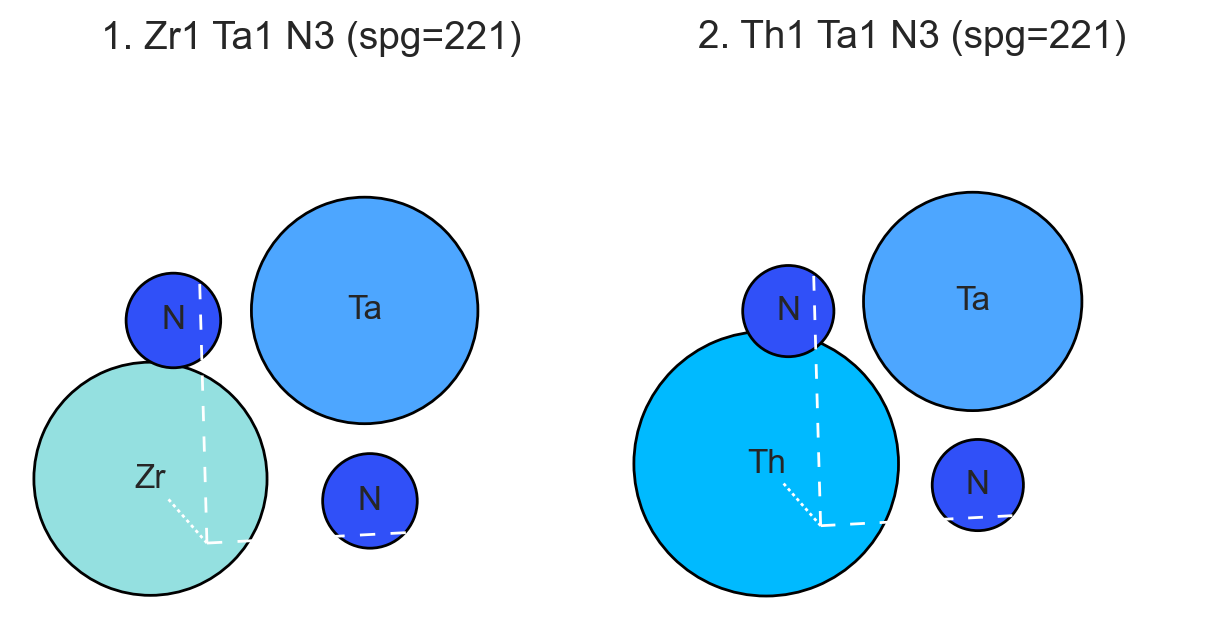

In [ ]:
# Define a composition which contains the ions Zr4+, Ta5+ and N3-
Zr_Ta_N_species = [
    ("Zr", 4),
    ("Ta", 5),
    ("N", -3),
]
parsed = [unparse_spec(s) for s in Zr_Ta_N_species]
threshold = 0.001
# Predict the possible structures that Zr4+, Ta5+ and N3- can be substituted onto
result = predictor.predict_structs(species=Zr_Ta_N_species, thresh=0.001, include_same=False)

# Show the first result

result_0 = next(result)

print(result_0)

print(
    f"\nUsing a threshold of {threshold}, the species {parsed} can be substituted into the structure of {result_0[2].reduced_formula()} with probability {result_0[1]:.3g}"
)

# Visualise the predicted and template structure

structs = [result_0[0].as_py_struct(), result_0[2].as_py_struct()]

pmv.structure_2d(structs)
plt.show()

Using the `StructurePredictor` class, we have shown that we can assign (Zr<sup>4+</sup>, Ta<sup>5+</sup>, N<sup>3-</sup>) to the perovskite ThTaN<sub>3</sub>, where Zr<sup>4+</sup> substitutes for Th<sup>4+</sup> with probability 0.0201.

We will show an example below, where we try to substitute the species (Cs<sup>+</sup>, Pb<sup>2+</sup>, I<sup>-</sup>) into the structures in our database.

The composition CsPbI3 has a probability of 0.139 of substiutuing into the structure of CsPbBr3
The composition CsPbI3 has a probability of 0.139 of substiutuing into the structure of CsPbBr3
The composition CsPbI3 has a probability of 0.0473 of substiutuing into the structure of CsSnI3
The composition CsPbI3 has a probability of 0.0175 of substiutuing into the structure of CsDyI3
The composition CsPbI3 has a probability of 0.00415 of substiutuing into the structure of CsPbF3


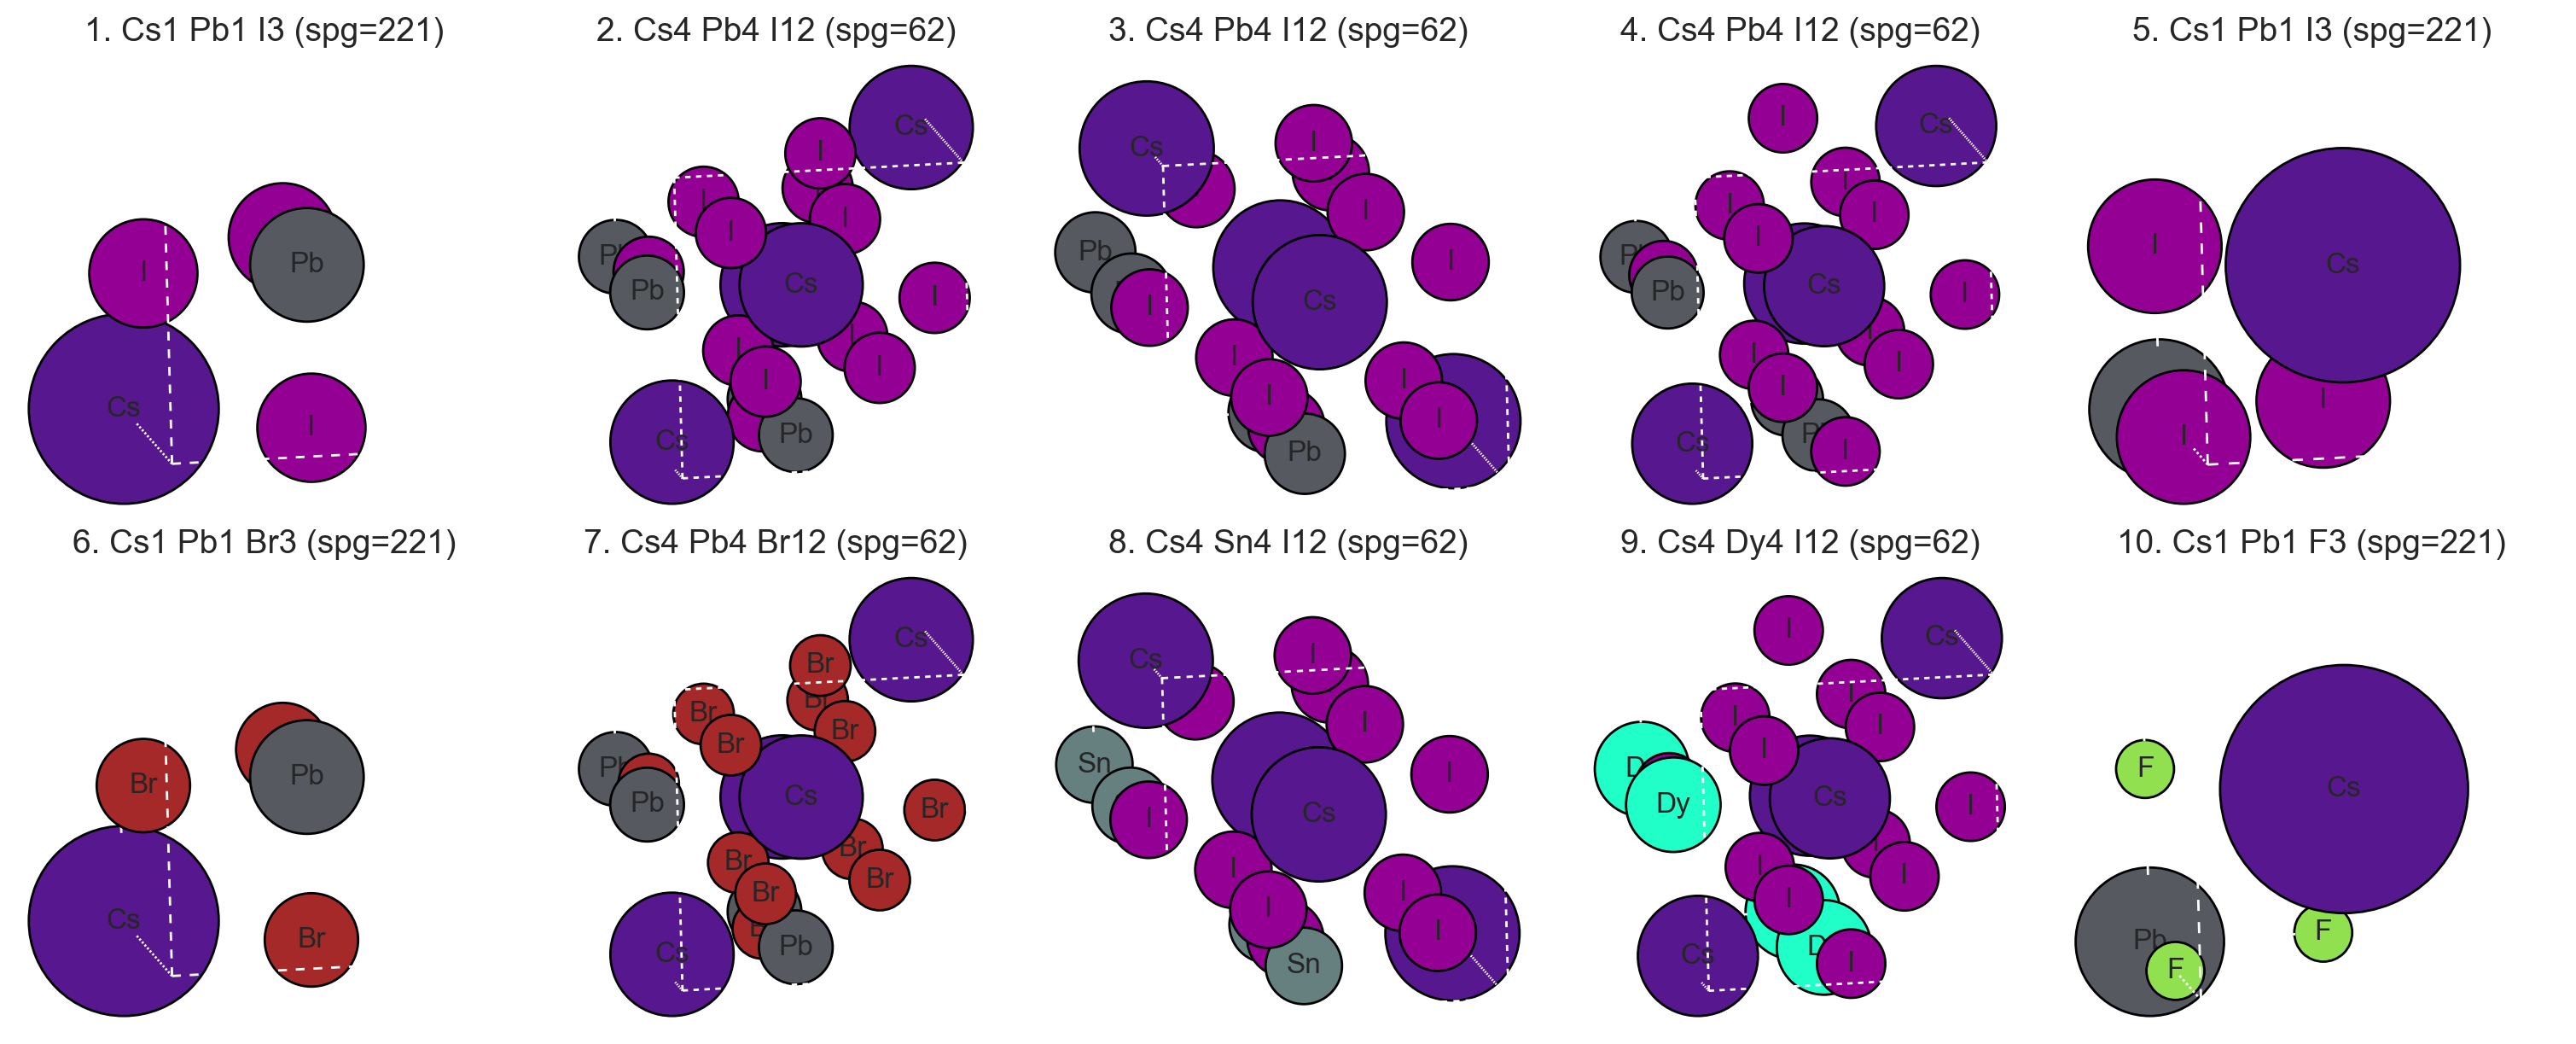

In [ ]:
cs_pb_I_species = [
    ("Cs", 1),
    ("Pb", 2),
    ("I", -1),
]

# Get the results for the substitution
cspbi_results = list(predictor.predict_structs(species=cs_pb_I_species, thresh=0.001, include_same=False))

# Sort the results by probabiblity
cspbi_results.sort(key=itemgetter(1), reverse=True)

for result in cspbi_results:
    print(
        f"The composition {result[0].reduced_formula()} has a probability of {result[1]:.3g} of substiutuing into the structure of {result[2].reduced_formula()}"
    )

# Visualise the predicted and original structures

predicted_structs = [result[0].as_py_struct() for result in cspbi_results]
db_structs = [result[2].as_py_struct() for result in cspbi_results]
structures = predicted_structs + db_structs


pmv.structure_2d(structures, n_cols=5)
plt.show()

The visualisation above depicts all the CsPbI<sub>3</sub> structures in the top row, and their templates in the bottom row.

## 2. Next Steps

This notebook has provided a simple introduction to the Structure Prediction module in SMACT.

For more advance work:

* Use the `smact_filter` function to build up a search space and attempt to predict the eneumerated compositions in a high-throughput manner
* Use the predicted structures as inputs to DFT/MLFF relaxation calculations
* Develop their own probability models to use with the `CationMutator` class.